In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from helpers.readers import read_dataframe

# Load datasets and prepare merged dataframes

In [3]:
cmu_movies = read_dataframe(
    name='cmu/movies',
    preprocess=True,
    usecols=[
        "Wikipedia movie ID",
        "Freebase movie ID",
        "Movie name",
        "Movie release date",
        "Movie box office revenue",
        "Movie runtime",
        "Movie languages",
        "Movie countries",
        "Movie genres",
    ]
)
imdb_info = read_dataframe(name='imdb/movies', preprocess=True)
imdb_ratings = read_dataframe(name='imdb/ratings')
movieLens_movies = read_dataframe(name='movieLens/movies', preprocess=True)
movieLens_ratings = read_dataframe('movieLens/ratings')

imdb_crew = read_dataframe(name='imdb/crew')
imdb_people = read_dataframe(name='imdb/names')
imdb_principals = read_dataframe(name='imdb/principals')

Preprocess logs:
✅ Fixed Movie Languages inside Movie Countries
✅ Removed Deseret characters
✅ Movie release date splitted to three columns: Movie release Year, Movie release Month, Movie release Day
✅ Seperated freebase identifiers from Movie Languages, Movie Countries and Movie Genres
Preprocess logs:
✅ Moved genres from runtimeMinutes to genres column
Preprocess logs:
✅ Aligned bad rows


## Prepare the movies dataframe

In [301]:
mapping_w_i_f = read_dataframe(name='mapping_wikipedia_imdb_freebase')
mapping_f_i = read_dataframe(name='mapping_freebase_imdb')

In [302]:
movies = cmu_movies.drop(['Movie release Day', 'Movie release Month'], axis=1).copy()

In [303]:
movies.rename(
    columns={
        'Wikipedia movie ID': 'wikipediaID',
        'Freebase movie ID': 'freebaseID',
        'Movie name': 'title',
        'Movie box office revenue': 'revenue',
        'Movie runtime': 'runtime',
        'Movie languages': 'languages',
        'Movie countries': 'countries',
        'Movie genres': 'genres',
        'Movie release Year': 'release',
    },
    inplace=True,
)

In [304]:
movies = movies.merge(
    right=mapping_f_i.drop_duplicates(subset='freebase'),
    left_on='freebaseID', right_on='freebase', how='left'
).rename(columns={'imdb': 'tconst'}).drop('freebase', axis=1)

In [305]:
movies.tconst.duplicated().sum()
movies.drop_duplicates(subset='tconst', inplace=True)

In [306]:
movies = movies.merge(
    right=imdb_info.rename(columns={'genres': 'genres_imdb', 'runtimeMinutes': 'runtime_imdb'})[['tconst', 'isAdult', 'runtime_imdb', 'genres_imdb']],
    on='tconst', how='left',
)

In [307]:
movies = movies.merge(
    right=imdb_ratings.rename(columns={'averageRating': 'rating', 'numVotes': 'votes'}),
    on='tconst', how='left',
)

In [11]:
# NOTE: Only adds ratings for 100 movies, not worth it

# movies = movies.merge(
#     right=movieLens_movies[['vote_average', 'vote_count', 'imdb_id']].rename(columns={'vote_average': 'rating_lens', 'vote_count': 'votes_lens', 'imdb_id': 'tconst'}),
#     on='tconst', how='left',
# )
# movies.rating_lens.replace(to_replace=0, value=pd.NA)

In [308]:
movies = movies.merge(right=imdb_crew.drop('writers', axis=1), on='tconst', how='left')

### The two cells below are for Q1, don't run them

In [309]:
imdb_people_exploded = imdb_people.copy()
imdb_people_exploded['knownForTitles'] = imdb_people['knownForTitles'].str.split(',')
imdb_people_exploded = imdb_people_exploded.explode(['knownForTitles'])


merged_ipe = pd.merge(imdb_people_exploded,mapping_f_i.drop_duplicates(subset='freebase'), how='inner', left_on='knownForTitles', right_on='imdb')
unique_matched_persons = merged_ipe.drop_duplicates(subset='nconst', keep='first')

In [14]:
matched_imdb_people = pd.merge(imdb_people, unique_matched_persons[['nconst']], on='nconst', how='inner')
tmp_principal_people = pd.merge(imdb_principals, matched_imdb_people[['nconst']], on='nconst', how='inner')
matched_principal_people = pd.merge(tmp_principal_people,mapping_f_i.drop_duplicates(subset='freebase')[['imdb']],left_on='tconst',right_on='imdb',how='inner')

## Prepare the directors dataframe

In [311]:
nmconsts = []
for item in movies.dropna(subset='directors').directors.str.split(','):
    nmconsts.extend(item)
nmconsts = set(nmconsts)

print(f'We have {len(nmconsts)} directors.')

We have 28498 directors.


In [312]:
directors = imdb_people[imdb_people.nconst.isin(nmconsts)].copy()

## Cells below until Working on Metrics are for Q1 as well, no need to run them

In [310]:
def get_movie_crew_size() :
    """ 
    Returns a dataframe containing all the people that worked on a movie, using the IMDb people data.

    Args:
    imdb_id: the IMDb ID of the movie

    Returns:
    movie_crew: A dataframe containing information of all people that worked on a film.
    """

In [50]:
import networkx as nx
from tqdm import tqdm

In [175]:
from collections import defaultdict
def counting_collaborations(directors_df, matched_imdb_people):
    """
    Returns a dictionnary containing the number of collaborations between directors and different crew members, for the movies selected.

    Args :
    directors_df : A dataframe containing information about directors. it must contain at least the two following columns : 'nconst', the personal
                   IMDb ID of the director, and 'knownForTitles' which are the titles for which the director is known.
    
                   
    matched_imdb_people : A dataframe containing personal information about people that have worked on movies that we decided to retain. Must also contain
                          the 'nconst' and 'knownForTitles' columns.
    
    """
    
    # Create a mapping of titles to people
    title_to_people = defaultdict(set)
    for _, person_row in tqdm(matched_imdb_people.iterrows()):
        person_id = person_row['nconst']
        titles = person_row['knownForTitles'].split(',')
        for title in titles:
            title_to_people[title].add(person_id)

    collaboration_counts = {}

    for _, row in tqdm(directors_df.iterrows()):
        director_ids = set(row['nconst'].split(',')) if isinstance(row['nconst'], str) else set()
        directed_titles = set(row['knownForTitles'].split(',')) if isinstance(row['knownForTitles'], str) else set()

        for director_id in director_ids:
            if director_id not in collaboration_counts:
                collaboration_counts[director_id] = {}

            for title in directed_titles:
                collaborators = title_to_people[title] - {director_id}  # Remove the director from collaborators
                for collaborator in collaborators:
                    if collaborator not in collaboration_counts[director_id]:
                        collaboration_counts[director_id][collaborator] = 1
                    else:
                        collaboration_counts[director_id][collaborator] += 1

    return collaboration_counts

In [75]:
def get_all_known_roles(matched_principal,all_matched_people) : 
    """
    Adds additional roles that people present in the matched_principal dataframe passed as argument have
    played.

    Args:
    matched_principal: The IMDb 'principal' dataframe matched for our selected movies. Contains
                       information about the 'principal' crew of each movie.

    all_matched_people: The IMDb 'people' dataframe matched for our selected movies. Contains
                        personal information about people in the film industry.

    Returns:
    enhanced_matched_principal: The all_matched_people dataframe passed as argument, with an additional column
                                containing any additional roles found in the matched_principal
                                dataframe. 
    """
    
    roles_collected = {}

    # Iterate over matched_principal to collect roles for each person
    for _, row in tqdm(matched_principal.iterrows()):
        nconst = row['nconst']
        tconst = row['tconst']
        
        if nconst not in roles_collected:
            roles_collected[nconst] = set()

        roles_collected[nconst].add(tconst)

    # Update enhanced_matched_principal with the collected roles
    enhanced_matched_principal = all_matched_people.copy()
    enhanced_matched_principal['all_known_roles'] = enhanced_matched_principal['nconst'].map(lambda x: ', '.join(map(str, roles_collected.get(x, []))))

    return enhanced_matched_principal

In [76]:
test = get_all_known_roles(matched_principal_people,matched_imdb_people)

617870it [00:30, 20470.01it/s]


In [176]:
collab_counts = counting_collaborations(directors,matched_imdb_people)

0it [00:00, ?it/s]

1476093it [02:48, 8755.46it/s] 
28498it [00:05, 5524.61it/s]


## Working on metrics

In [313]:
from helpers.readers import read_dataframe
awards = read_dataframe('imdb/awards')

## Including the awards in movie success

In [314]:
#Only keeping the movies awards for now, discarding the ones for the actors.
movie_awards = awards[awards['isTitle']]
cmu_imdb_awards = pd.merge(movie_awards,movies['tconst'], left_on='const',right_on='tconst',how='inner').drop(columns=['tconst'])
cmu_imdb_awards.const.nunique()

29038

In [315]:
nominations_per_movie = cmu_imdb_awards.groupby(['const', 'eventName', 'year']).agg({
    'categoryName': ['size', lambda x: ', '.join(x.fillna('Not mentioned'))],
    'isWinner': lambda x: x.tolist()
}).reset_index()

# Rename the columns for clarity
nominations_per_movie.columns = ['tconst', 'eventName', 'year', 'numNominations', 'nominationsList', 'isWinnerList']

What i try to do here is to use :
- The number of events the movie was nominated in
- The total movie nominations
- The total number of wins within those nominations

And to have a weighted sum of  (the log of) these three factors. Can surely be improved, most likely not optimal

In [316]:
movies_total_events = nominations_per_movie.groupby(['tconst', 'eventName', 'year']).size().groupby('tconst').size()
movies_total_nominations = nominations_per_movie.groupby('tconst')['numNominations'].sum()
movies_total_wins = nominations_per_movie.groupby('tconst')['isWinnerList'].apply(lambda x: sum(event.count('True') for event in x))
movies_metric = pd.DataFrame({
    'tconst': movies_total_events.index,
    'total_events': movies_total_events.values,
    'total_nominations': movies_total_nominations.values,
    'total_wins': movies_total_wins.values
})


movies_metric['movie_awards_success'] = (0.1 * np.log1p(movies_metric['total_events']) +
                                    0.6 * np.log1p(movies_metric['total_nominations']) +
                                    0.3 * np.log1p(movies_metric['total_wins']))


#from sklearn.preprocessing import StandardScaler
#
#scaler = StandardScaler()
#movies_metric_standardized = scaler.fit_transform(movies_metric[['total_events', 'total_nominations', 'total_wins']])
#movies_metric['movie_awards_success'] = (
#    movies_metric_standardized[:, 0] +
#    0.75 * movies_metric_standardized[:, 1] +
#    0.25 * movies_metric_standardized[:, 2]
#)

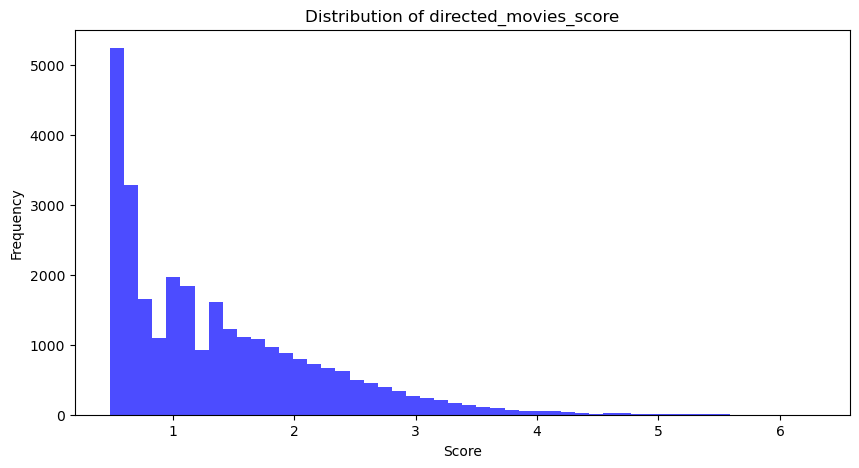

In [317]:
movie_awards_success = movies_metric.loc[movies_metric['movie_awards_success'] > 0, 'movie_awards_success']

plt.figure(figsize=(10, 5))
plt.hist(movie_awards_success, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of directed_movies_score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [286]:
movies_metric.sort_values(by='movie_awards_success', ascending=False)[:10]

,tconst,total_events,total_nominations,total_wins,movie_awards_success
3812,tt0056758,200,864,285,6.284766
4972,tt0065272,183,764,191,6.082668
4147,tt0058796,184,689,226,6.071536
26173,tt1392190,115,458,240,5.798228
26473,tt1454468,124,414,238,5.742738
24383,tt1065073,110,381,171,5.582454
14438,tt0167260,95,328,206,5.533885
26107,tt1375666,104,362,156,5.518911
27404,tt1655442,107,358,158,5.518878
25633,tt1285016,96,345,168,5.504304


We include these new scores into the movies dataframe,

In [319]:
movies = pd.merge(movies,movies_metric, on='tconst').drop(columns=['total_events','total_nominations','total_wins'])

We include this metric in addition to the original metric (only using votes) that we had .

The exact formula to use is still something idk, the one below hasn't been thought through, it's just to include it for now

In [352]:
def metric(row):
    return np.log10(row['votes']) * (row['rating']) + (row['movie_awards_success'] ** 1.5)
movies['score'] = movies.apply(metric, axis=1)

## Director's awards success

In [321]:
dir_awards = awards[~awards['isTitle']]

In [322]:
directors_awards = (pd.merge(dir_awards,directors['nconst'],left_on= 'const', right_on='nconst', how='inner')).drop('const',axis=1)

directors_awards['categoryName_lower'] = directors_awards['categoryName'].str.lower()
directors_awards['nomeneeNote_lower'] = directors_awards['nomeneeNote'].str.lower()

directors_awards['isPrimary'] = directors_awards['isPrimary'].astype(bool)
directors_awards['isSecondary'] = directors_awards['isSecondary'].astype(bool)

# Filter awards for directorial roles
directors_awards = directors_awards[
    (directors_awards['isPrimary'] | directors_awards['isSecondary']) & 
    ((directors_awards['categoryName_lower'].isna()) | (~directors_awards['categoryName_lower'].str.contains('actor|actress'))) & 
    ((directors_awards['nomeneeNote_lower'].isna()) | (~directors_awards['nomeneeNote_lower'].str.contains('actor|actress')))
]

# Drop the temporary lowercase columns
directors_awards = directors_awards.drop(['categoryName_lower', 'nomeneeNote_lower'], axis=1)

display(directors_awards)

,eventId,eventName,awardName,year,occurrence,winAnnouncementTime,categoryName,nomeneeNote,name,originalName,...,episodeNames,characterNames,isWinner,isPrimary,isSecondary,isPerson,isTitle,isCompany,notes,nconst
0,ev0000263,French Syndicate of Cinema Critics,Critics Award,1992,1,NaN,Best Film,<NA>,Jacques Rivette,<NA>,...,<NA>,<NA>,True,True,True,True,False,False,<NA>,nm0729626
1,ev0000091,Berlin International Film Festival,Golden Berlin Bear,2007,1,NaN,<NA>,<NA>,Jacques Rivette,<NA>,...,<NA>,<NA>,False,True,True,True,False,False,<NA>,nm0729626
2,ev0000400,Locarno International Film Festival,Special Prize of the Jury,1974,1,NaN,<NA>,<NA>,Jacques Rivette,<NA>,...,<NA>,<NA>,True,True,True,True,False,False,<NA>,nm0729626
3,ev0001574,Gaudí Awards,Gaudí Award,2009,1,NaN,Best European Film (Millor Pel·lícula Europea),(director),Jacques Rivette,<NA>,...,<NA>,<NA>,False,True,True,True,False,False,France/Italy,nm0729626
4,ev0000450,Moscow International Film Festival,Golden St. George,1995,1,NaN,<NA>,<NA>,Jacques Rivette,<NA>,...,<NA>,<NA>,False,True,True,True,False,False,<NA>,nm0729626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187216,ev0000091,Berlin International Film Festival,Golden Berlin Bear,1960,1,NaN,<NA>,<NA>,Ville Salminen,<NA>,...,<NA>,<NA>,False,True,True,True,False,False,<NA>,nm0758744
187217,ev0000091,Berlin International Film Festival,Golden Berlin Bear,1960,1,NaN,<NA>,<NA>,Prabhat Mukherjee,<NA>,...,<NA>,<NA>,False,True,True,True,False,False,<NA>,nm0611542
187218,ev0000091,Berlin International Film Festival,Silver Berlin Bear,1960,1,NaN,Special Prize - Short Film,<NA>,Juan Berend,<NA>,...,<NA>,<NA>,True,True,True,True,False,False,<NA>,nm0073501
187219,ev0000409,AFI Fest,Documentary Award - Special Mention,2001,1,NaN,<NA>,<NA>,Jan Louter,<NA>,...,['A Sad Flower in the Sand (#8.7)'],<NA>,True,True,True,True,False,False,"For episode ""A Sad Flower in the Sand (#8.7)"".",nm1098324


We count number of nominations and wins,

In [323]:
import pandas as pd

# Count total nominations (wins + losses) for each nconst
total_nominations = directors_awards.groupby('nconst').size().reset_index(name='total_nominations')

# Count number of wins for each nconst
wins_count = directors_awards[directors_awards['isWinner'] == 'True'].groupby('nconst').size().reset_index(name='wins_count')

# Merge the two counts based on 'nconst'
nominations_and_wins = pd.merge(total_nominations, wins_count, on='nconst', how='left').fillna(0)
nominations_and_wins['wins_count'] = nominations_and_wins['wins_count'].astype(int)
nominations_and_wins['total_nominations'] = nominations_and_wins['total_nominations'].astype(int)

display(nominations_and_wins)

,nconst,total_nominations,wins_count
0,nm0000005,130,76
1,nm0000008,15,8
2,nm0000009,13,8
3,nm0000018,40,27
4,nm0000019,114,65
...,...,...,...
16444,nm8956708,1,1
16445,nm9054338,2,1
16446,nm9335192,2,1
16447,nm9801575,1,0


In [324]:
directors = pd.merge(directors,nominations_and_wins,on='nconst',how='left')
directors['total_nominations'].fillna(0, inplace=True)
directors['wins_count'].fillna(0, inplace=True)
directors['total_nominations'] = directors['total_nominations'].astype(int)
directors['wins_count'] = directors['wins_count'].astype(int)
display(directors)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,total_nominations,wins_count
0,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0083922,tt0050976,tt0069467",130,76
1,nm0000008,Marlon Brando,1924,2004,"actor,soundtrack,director","tt0047296,tt0078788,tt0070849,tt0068646",15,8
2,nm0000009,Richard Burton,1925,1984,"actor,soundtrack,producer","tt0087803,tt0057877,tt0059749,tt0061184",13,8
3,nm0000018,Kirk Douglas,1916,2020,"actor,producer,soundtrack","tt0049456,tt0050825,tt0054331,tt0080736",40,27
4,nm0000019,Federico Fellini,1920,1993,"writer,director,actor","tt0050783,tt0053779,tt0056801,tt0071129",114,65
...,...,...,...,...,...,...,...,...
28493,nm9923550,Peder Pedersen,<NA>,<NA>,"director,miscellaneous,editor","tt1989553,tt1441426,tt0497368,tt1504682",0,0
28494,nm9928872,K.S. Raveendran,<NA>,<NA>,"writer,director",tt4507090,0,0
28495,nm9965211,Vasanth Balan,<NA>,<NA>,director,tt8685998,0,0
28496,nm9965267,Ramesh Khanna,<NA>,<NA>,director,tt0274959,0,0


In the same manner as before but for directors, trying to have a weighted sum of some sort + log at the end to smooth it out of those two elements. Haven't included the number of events here, i guess we could include it

In [325]:
def awards_metric(row,max_nominations,max_wins):
    # Extract relevant data from the row
    total_nominations = row['total_nominations']
    wins_count = row['wins_count']

    normalized_nominations = total_nominations / max_nominations if max_nominations > 0 else 0
    normalized_wins = wins_count / max_wins if max_wins > 0 else 0

    weight_nominations = 0.3
    weight_wins = 0.7

    sw = (weight_nominations * normalized_nominations) + (weight_wins * normalized_wins)
    scaled_sw = np.log1p(sw * 100)

    return scaled_sw

max_nominations = directors['total_nominations'].max()
max_wins = directors['wins_count'].max()

directors['awards_success'] = directors.apply(
    lambda row: awards_metric(row, max_nominations, max_wins),
    axis=1
)

In [327]:
directors.sort_values(by='awards_success', ascending=False)[:10][['nconst','primaryName','awards_success']]

,nconst,primaryName,awards_success
4444,nm0190859,Alfonso Cuarón,4.615121
81,nm0000229,Steven Spielberg,4.371868
78,nm0000217,Martin Scorsese,4.313302
84,nm0000233,Quentin Tarantino,4.303186
314,nm0001054,Joel Coen,4.233572
92,nm0000264,Pedro Almodóvar,4.207054
12833,nm0634240,Christopher Nolan,4.146630
26,nm0000095,Woody Allen,4.110234
313,nm0001053,Ethan Coen,4.069328
7866,nm0381116,Don Hertzfeldt,4.067701


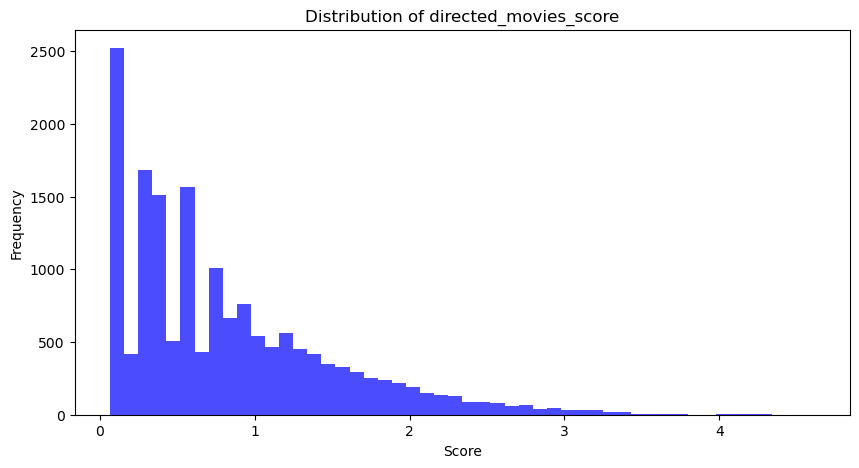

In [328]:
valid_awards_success = directors.loc[directors['awards_success'] > 0, 'awards_success']

plt.figure(figsize=(10, 5))
plt.hist(valid_awards_success, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of directed_movies_score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

A lot of directors with no nominations/prizes, but still an interesting metric to take into account. 

In the histogram above, i removed all 0 values, which leaves us with 16k directors with awards information.

Weights were taken completely arbitrarily, we can try others / a different type of weighted sum. I emphasized wins over nominations, but we can try differently.

In any case, the distribution is always going to be skewed with some directors rarely nominated/won. But, i think it's still a good metric : we have enough info, we just have to agree how we define it exactly.

### Director's movie success

In [354]:
def directed_movies_metrics(director):
    directed_movies = movies[movies.directors.str.contains(director.nconst)]
    score = {
        'hits-0': ((directed_movies.score >= 0) & (directed_movies.score < 10)).sum(),
        'hits-10': ((directed_movies.score >= 10) & (directed_movies.score < 20)).sum(),
        'hits-20': ((directed_movies.score >= 20) & (directed_movies.score < 30)).sum(),
        'hits-30': ((directed_movies.score >= 30) & (directed_movies.score < 40)).sum(),
        'hits-40': ((directed_movies.score >= 40) & (directed_movies.score < 45)).sum(),
        'hits-45': ((directed_movies.score >= 45) & (directed_movies.score < 50)).sum(),
        'hits-50': (directed_movies.score >= 50).sum(),
        'rate-7.0': len(directed_movies.query('rating >= 7.0 & votes >= 1000')),
        'rate-7.5': len(directed_movies.query('rating >= 7.5 & votes >= 1000')),
        'rate-8.0': len(directed_movies.query('rating >= 8.0 & votes >= 1000')),
        'rate-8.5': len(directed_movies.query('rating >= 8.5 & votes >= 1000')),
    }
    for n in [3, 5, 10]:
        if len(directed_movies.score.dropna()) < n:
            score[f'avg-{n}'] = pd.NA
        else:
            score[f'avg-{n}'] = directed_movies.score.sort_values(ascending=False)[:n].mean()

    return score

directors['score'] = directors.apply(directed_movies_metrics, axis=1)

C:\Users\dryha\AppData\Local\Temp\ipykernel_14812\2126237102.py:20: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  score[f'avg-{n}'] = directed_movies.score.sort_values(ascending=False)[:n].mean()
C:\Users\dryha\AppData\Local\Temp\ipykernel_14812\2126237102.py:20: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  score[f'avg-{n}'] = directed_movies.score.sort_values(ascending=False)[:n].mean()
C:\Users\dryha\AppData\Local\Temp\ipykernel_14812\2126237102.py:20: FutureWarning: The behav

In [363]:
for key in directors.iloc[0].score.keys():
    directors[key] = directors.apply(lambda d: d.score[key], axis=1)

directors.drop('score', axis=1, inplace=True)

Let's try to have another score besides the 'avg-3' one. 'avg-3' is good, the motivation here is to get a metric that could maybe apply to a larger number of directors.

The idea is to use the 'hits-{...}' columns to quantify the success of the director's directed movies, using the movie scores. Keeping in mind the Martin Scorcese example, we will try to weight the hits in order to 'weight up' the ones that were very successful. We do not care if a few movies were maybe not as successful : what really define bright directors is their hits. However, i still hope that if a director had many unsuccessful movies it will still rank them low.


$$ \text{Score}_{\text{directed\_movies\_final}} = \sqrt{\sum_{i} \left( \text{Weight}_i \times \log(\text{hits}_i + 1) \right)} $$

Where:
- $ i $ is the index of the 'hits-{...}' category.
- $ \text{Weight}_i $ is the weight assigned to the 'hits-{...}' category.
- $ \text{hits}_i $ is the value of the 'hits-{...}' category for the director.
- $ \max(\text{hits}_i) $ is the maximum value in the 'hits-{...}' category across all directors.



In [499]:
weights = {
    'hits-0': 1,
    'hits-10': 2,
    'hits-20': 4,
    'hits-30': 6,
    'hits-40': 10,
    'hits-45': 14,
    'hits-50': 20,
}

for index, row in directors.iterrows():
    total_score = 0
    for column, weight in weights.items():
        hits_column = f'{column}'
        if not pd.isna(row[hits_column]):
            log_hits = np.log1p(row[hits_column])
            total_score += (log_hits) * weight

    directors.at[index, 'directed_movies_score'] = np.sqrt(total_score)

In [500]:
directors.sort_values(by='directed_movies_score', ascending=False)[:15][['nconst','primaryName','awards_success','directed_movies_score','avg-3']]

,nconst,primaryName,awards_success,directed_movies_score,avg-3
81,nm0000229,Steven Spielberg,4.371868,10.570120,62.246815
78,nm0000217,Martin Scorsese,4.313302,9.488288,61.941705
6,nm0000033,Alfred Hitchcock,2.627856,9.407305,52.447394
47,nm0000142,Clint Eastwood,4.057330,9.309409,55.931179
314,nm0001054,Joel Coen,4.233572,9.082441,57.218259
198,nm0000631,Ridley Scott,3.112989,9.066648,57.582714
26,nm0000095,Woody Allen,4.110234,8.994958,49.454657
313,nm0001053,Ethan Coen,4.069328,8.908800,57.218259
109,nm0000318,Tim Burton,2.712534,8.858359,49.984643
58,nm0000165,Ron Howard,2.940282,8.744222,53.549559


In [501]:
directors.sort_values(by='avg-3', ascending=False)[:15][['nconst','primaryName','awards_success','directed_movies_score','avg-3']]

,nconst,primaryName,awards_success,directed_movies_score,avg-3
12833,nm0634240,Christopher Nolan,4.146630,7.250859,68.313762
404,nm0001392,Peter Jackson,4.046675,7.559237,67.817948
84,nm0000233,Quentin Tarantino,4.303186,8.150945,64.69338
81,nm0000229,Steven Spielberg,4.371868,10.570120,62.246815
78,nm0000217,Martin Scorsese,4.313302,9.488288,61.941705
132,nm0000399,David Fincher,3.460522,7.352769,60.652904
113,nm0000338,Francis Ford Coppola,3.047580,8.544189,60.457885
37,nm0000116,James Cameron,3.389581,7.252727,59.736495
217,nm0000709,Robert Zemeckis,2.722743,8.559506,58.398955
17477,nm0881279,Lee Unkrich,2.582583,5.673514,57.814269


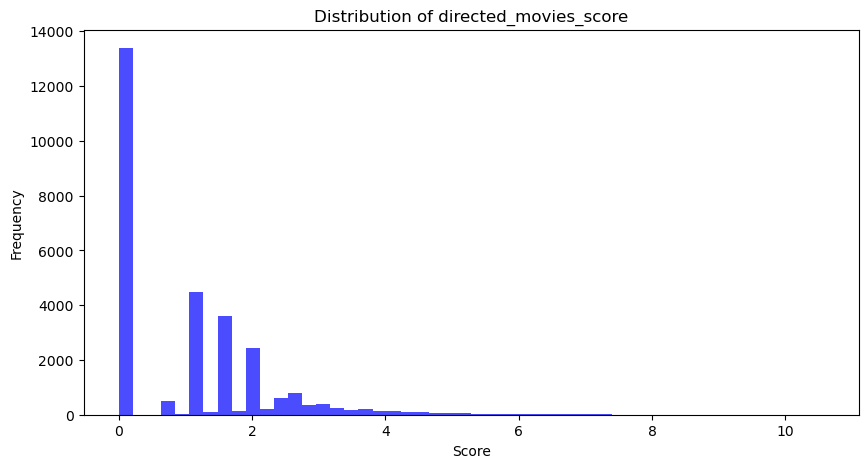

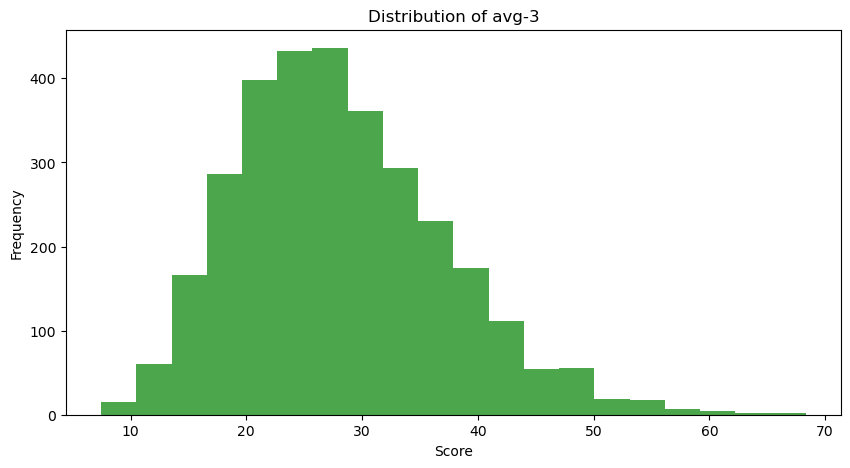

In [502]:
plt.figure(figsize=(10, 5))
plt.hist(directors['directed_movies_score'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of directed_movies_score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for 'avg-3'
plt.figure(figsize=(10, 5))
plt.hist(directors['avg-3'].dropna(), bins=20, color='green', alpha=0.7)
plt.title('Distribution of avg-3')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

--> Go for 'avg-3' as the main metric for 'movies directed success' of each director. The other metric is too heavily impacted by very successful directors with a lot of hit movies, i don't think it'll be good

In a sense, we loose a bit of info by only considering the three most successful movies for each director, but :

- As we said, one justification is saying that we only care about the best hits of each director, not the less succesful movies
of the directors

- We can also argue that by taking the director's awards information into account in another metric, this is where we take the 'entire career' of directors into account. For instance, if two directors have had their 3 most successful movies that are equally rated, but director 1 has had more success during his career, it is not unreasonable to think that they will have a higher awards score in the end. 


Idk if the awards metric is enough to differentiate directors that have a few hits with directors that spent their career being 'bright', but i still think we have to differentiate them a little in some way. Not necessarily hugely as it would skew the reparition, but still.

Maybe retry with a similar metric that I used here but differently ?

## left to do : how do we combine awards + movie success for directors into one metric ?